*disclaimer: this is not an official Digital Earth African notebook*

# Water detection and dam monitoring with Sentinel 2 imagery <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[WOfS](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) and [s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background
The United Nations have prescribed 17 *"Sustainable Development Goals"* (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook, like the [Water_extent.ipynb](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Real_world_examples/Water_extent.ipynb), primarily focuses on the first sub-indicator - spatial extents. It uses the annual  [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) as validation and the [Sentinel 2](https://explorer.digitalearth.africa/s2_l2a) for monitoring.

In [1]:
#load the magic
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import os
import sys
import xarray as xr
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd

from affine import Affine

import datacube
from datacube.utils.cog import write_cog

sys.path.append('../Scripts')
from deafrica_datahandling import mostcommon_crs
from deafrica_datahandling import load_ard, wofs_fuser
from deafrica_spatialtools import xr_vectorize, xr_rasterize
from deafrica_plotting import xr_animation
from deafrica_plotting import display_map, rgb, map_shapefile
from deafrica_bandindices import calculate_indices
from deafrica_classificationtools import HiddenPrints
from deafrica_dask import create_local_dask_cluster

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)
/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
dc = datacube.Datacube(app="water_Theewaterskloof")

In [3]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:39089' processes=1 threads=2, memory=14.18 GB>

## Validation
We query [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) and retrieve a validation dataset.
- Then we filter the dataset to only include the necessary *- We will use this later as a mask to investigate a specific area.*

In [4]:
#enter a location
lat, lon = -34.02, 19.212
buffer = 0.09

# Create a query
wofs_query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    
    #we set 2015 as the validation year
    'time': ('2015'),
    #crs = utm34S
    'output_crs':'EPSG:22234'
}

# Load WoFS through the datacube
ds = dc.load(product='ga_ls8c_wofs_2_annual_summary', 
             align=(15, 15),
             resolution=(-30, 30),
             **wofs_query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, x: 567, y: 676)
Coordinates:
  * time         (time) datetime64[ns] 2015-07-02T11:59:59.999500
  * y            (y) float64 6.245e+06 6.245e+06 ... 6.224e+06 6.224e+06
  * x            (x) float64 3.265e+05 3.265e+05 ... 3.434e+05 3.434e+05
    spatial_ref  int32 22234
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 16 16 16 16 16 16 16 ... 18 17 17 17 17 17
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:22234
    grid_mapping:  spatial_ref


### Plot the WOfS summary and Vectorize an `xarray.DataArray`

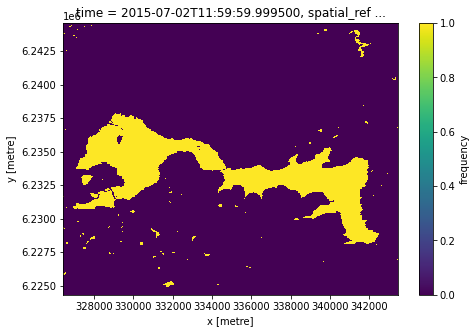

In [5]:
# Select pixels that are classified as water > 40 % of the year
water_bodies = ds.frequency > 0.40

# Plot the data
water_bodies.plot(size=5)
plt.show()

In [6]:
#vectorize
gdf = xr_vectorize(water_bodies,
                   crs=ds.crs,
                   transform=ds.geobox.transform,
                   mask=water_bodies.values==1)

#print(gdf.head())

### Basic cleaning

> Set a minimum area to exclude smaller water bodies.

In [7]:
#we create a new dataframe with polygon.area > 1 000 000
gdf_clean = gdf[gdf['geometry'].area > 1000000].copy()

#reset index
gdf_clean.reset_index(drop=True, inplace=True)

#add an 'id' and area column
gdf_clean['id'] = range(0, len(gdf_clean))
field = 'id'
gdf_clean['area'] = gdf['geometry'].area

In [8]:
#check how they differ
print(len(gdf))
print(len(gdf_clean))

150
3


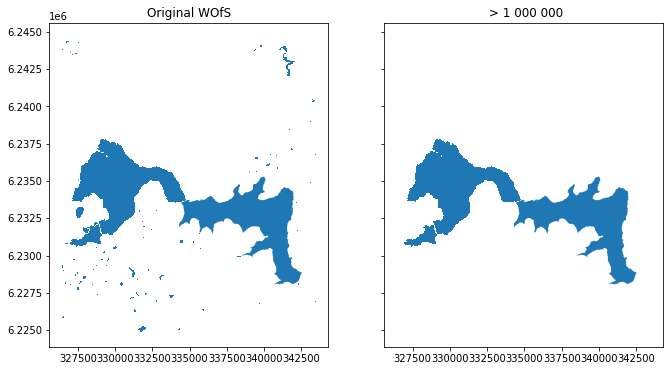

In [9]:
# Plot the two
fig, ax = plt.subplots(1, 2, figsize=(11, 9), sharex=True, sharey=True)

gdf.plot(ax=ax[0])
gdf_clean.plot(ax=ax[1])
#title
ax[0].set_title('Original WOfS')
ax[1].set_title(' > 1 000 000')

plt.show()

In [10]:
#check the .crs
gdf_clean.crs

<Projected CRS: EPSG:22234>
Name: Cape / UTM zone 34S
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: Cape
- Ellipsoid: Clarke 1880 (Arc)
- Prime Meridian: Greenwich

In [11]:
#check the polygon over laps the area of interest visually
map_shapefile(gdf_clean, attribute=field)

Label(value='')

Map(center=[-34.03375882863192, 19.20872447874712], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [12]:
#have a look at the data
gdf_clean

attribute                                           geometry  id    area
0        1.0  POLYGON ((329085.000 6237825.000, 329085.000 6...   0   900.0
1        1.0  POLYGON ((328845.000 6232095.000, 328845.000 6...   1  5400.0
2        1.0  POLYGON ((339975.000 6235305.000, 339975.000 6...   2   900.0

In [ ]:
#not necessary
#display_map(x=(lon-buffer, lon+buffer), y=(lat+buffer, lat-buffer))

## Load Sentinel 2 data

In [13]:
# Define the start year and end year
start_year = '2017-01-01'
end_year = '2020-08-01'

#Create a query object
sen_query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'resolution': (-10, 10),
    'output_crs':'EPSG:22234',
    'group_by': 'solar_day',
    'time': (start_year, end_year),
    'dask_chunks':{'time':1,'x':1000,'y':1000}
}

In [14]:
ds_sen2 = load_ard(dc=dc,
                      products=['s2_l2a'],
                      measurements=['red', 'green', 'blue', 'nir'],
                      min_gooddata = 0.75,
                      **sen_query)

../Scripts/deafrica_datahandling.py:240: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 125 out of 236 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Returning 125 time steps as a dask array


/env/lib/python3.6/site-packages/odc/algo/_masking.py:51: PendingDeprecationWarning: Dataset.apply may be deprecated in the future. Using Dataset.map is encouraged
  keep_attrs=True)
/env/lib/python3.6/site-packages/odc/algo/_masking.py:148: PendingDeprecationWarning: Dataset.apply may be deprecated in the future. Using Dataset.map is encouraged
  keep_attrs=True)


In [15]:
ds_sen2.crs

'EPSG:22234'

In [ ]:
#ds_sen2.transform

In [16]:
ds_sen2.affine

Affine(10.0, 0.0, 326460.0,
       0.0, -10.0, 6244600.0)

## Compute band indices

In [17]:
# Calculate NDWI and add it to the loaded data set
ds_sen2 = calculate_indices(ds_sen2, index="NDWI", collection="s2")
ds_index = ds_sen2.NDWI

In [18]:
print(ds_sen2)

<xarray.Dataset>
Dimensions:      (time: 125, x: 1698, y: 2026)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01T08:45:43 ... 2020-07-19T08:...
  * y            (y) float64 6.245e+06 6.245e+06 ... 6.224e+06 6.224e+06
  * x            (x) float64 3.265e+05 3.265e+05 ... 3.434e+05 3.434e+05
    spatial_ref  int32 22234
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    NDWI         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:22234
    grid_mapping:  spatial_ref


In [19]:
print(ds_sen2.NDWI)

<xarray.DataArray 'NDWI' (time: 125, y: 2026, x: 1698)>
dask.array<truediv, shape=(125, 2026, 1698), dtype=float32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01T08:45:43 ... 2020-07-19T08:...
  * y            (y) float64 6.245e+06 6.245e+06 ... 6.224e+06 6.224e+06
  * x            (x) float64 3.265e+05 3.265e+05 ... 3.434e+05 3.434e+05
    spatial_ref  int32 22234


## Mask area with the WOfS data *(water extent)*

In [20]:
#set polygons as mask 
with HiddenPrints():
    mask = xr_rasterize(gdf_clean, ds_sen2)
ds_sen2 = ds_sen2.where(mask)

## Calculate the area per pixel and the extent of water

In [21]:
#Calculate the area per pixel

pixel_length = sen_query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [22]:
# Filter the data to contain only pixels classified as water
ds_waterarea = ds_sen2.where(ds_sen2.NDWI > 0.1)

# Calculate the total water area (in km^2)
waterarea = (
    ds_waterarea.NDWI.count(dim=["x", "y"])
    .rolling(time=3, center=True, min_periods=1)
    .median(skipna=True)
    * area_per_pixel
)

### Plot Monthly Time Series from the `Start year` to `End year`

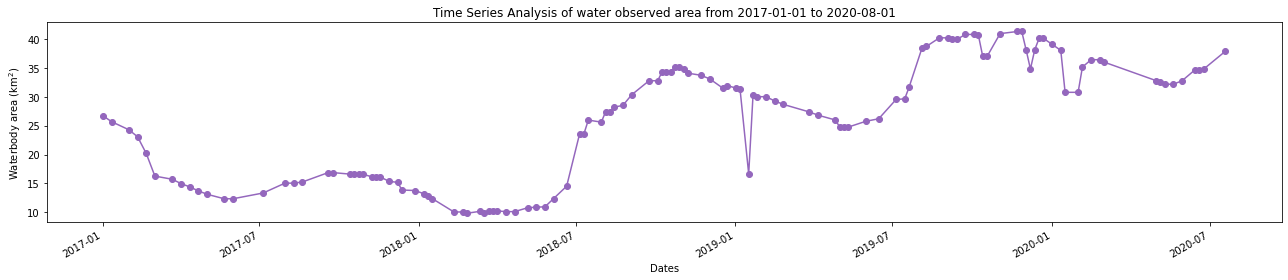

In [23]:
#graph
plt.figure(figsize=(18, 4))
waterarea.plot(marker='o', color='#9467bd')
plt.title(f'Time Series Analysis of water observed area from {start_year} to {end_year}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

### Select a range and Plot

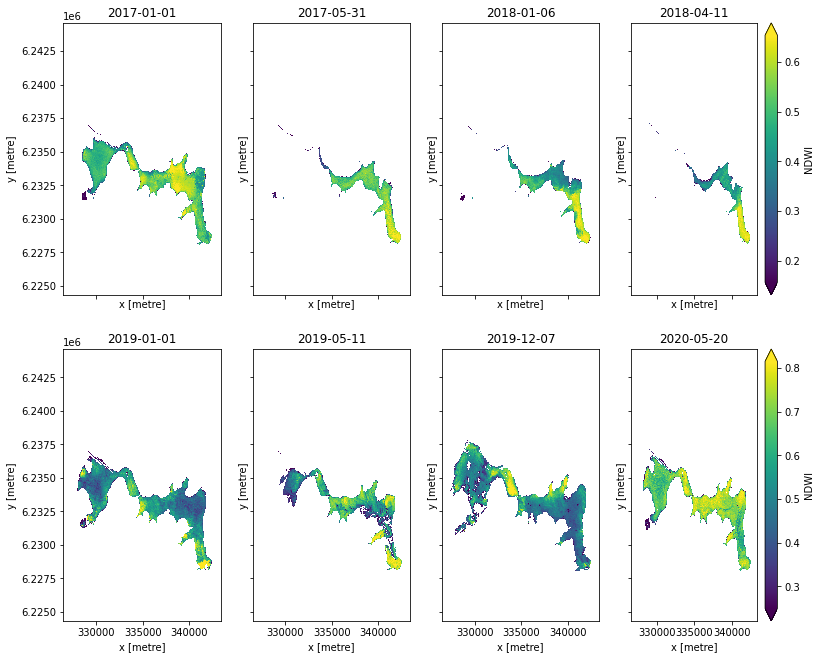

In [24]:
#index
time_stamp = [0, 12, 30, 41, 70, 83, 104, 119]

#      **** the code below should be more effective with ****

#fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharex=True, sharey=True)
#fig.subplots_adjust(hspace = .5, wspace=.001)
#for i, ax in zip(time_stamp, axs.flatten()):
            #ax.imshow(ds_waterarea.NDWI.isel(time=time_stamp[i]), cmap="viridis")
            #ax.set_title(ds_waterarea.NDWI.isel(time=time_stamp[i]).time.dt.strftime('%Y-%m-%d').data)
#plt.show()

                    #    ***** but I can't seem to get it right  *****

# Plot water extent
fig, ax = plt.subplots(2, 4, figsize=(13, 11), sharex=True, sharey=True)

# plot the water extent from WOfS
#ds_wofs.isel(time=timestep_1).water.plot.imshow(ax=ax[1], cmap="Blues", add_colorbar=False)

ds_waterarea.NDWI.isel(time=time_stamp[0]).plot.imshow(ax=ax[0,0],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[1]).plot.imshow(ax=ax[0,1],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[2]).plot.imshow(ax=ax[0,2],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[3]).plot.imshow(ax=ax[0,3],cmap="viridis",robust=True, add_colorbar=True)
ds_waterarea.NDWI.isel(time=time_stamp[4]).plot.imshow(ax=ax[1,0],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[5]).plot.imshow(ax=ax[1,1],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[6]).plot.imshow(ax=ax[1,2],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[7]).plot.imshow(ax=ax[1,3],cmap="viridis",robust=True, add_colorbar=True)

#title
ax[0,0].set_title(ds_waterarea.isel(time=time_stamp[0]).time.dt.strftime('%Y-%m-%d').data)#'2017-01')
ax[0,1].set_title(ds_waterarea.isel(time=time_stamp[1]).time.dt.strftime('%Y-%m-%d').data)#'2017-07')
ax[0,2].set_title(ds_waterarea.isel(time=time_stamp[2]).time.dt.strftime('%Y-%m-%d').data)#'2018-01')
ax[0,3].set_title(ds_waterarea.isel(time=time_stamp[3]).time.dt.strftime('%Y-%m-%d').data)#'2018-06') #this is actually the fifth month
ax[1,0].set_title(ds_waterarea.isel(time=time_stamp[4]).time.dt.strftime('%Y-%m-%d').data)#'2019-01')
ax[1,1].set_title(ds_waterarea.isel(time=time_stamp[5]).time.dt.strftime('%Y-%m-%d').data)#'2019-06')
ax[1,2].set_title(ds_waterarea.isel(time=time_stamp[6]).time.dt.strftime('%Y-%m-%d').data)#'2020-01')
ax[1,3].set_title(ds_waterarea.isel(time=time_stamp[7]).time.dt.strftime('%Y-%m-%d').data)#'2020-06')

# set labels
#plt.setp(ax[-1, :], xlabel='x axis label')
#plt.setp(ax[:, 0], ylabel='y axis label')

plt.show()

## Export Geotiff

In [25]:
#export geotiff for selected timestamps

#index
time_stamp = [0, 12, 30, 41, 70, 83, 104, 119]

for i in time_stamp:

    # We will use the date of the satellite image to name the GeoTIFF
    date = ds_waterarea.isel(time=i).time.dt.strftime('%Y-%m-%d').data

    # Convert current time step into a `xarray.DataArray`
    singletimestamp_da = ds_waterarea.isel(time=i).to_array()
    
    # Write GeoTIFF
    write_cog(geo_im = singletimestamp_da,
              fname = f'{date}.tif',
              overwrite=False).compute()
    print(f'Writing {date}')


Writing 2017-01-01
Writing 2017-05-31
Writing 2018-01-06
Writing 2018-04-11
Writing 2019-01-01
Writing 2019-05-11
Writing 2019-12-07
Writing 2020-05-20


## Produce an animation and export a `.gif`

Exporting animation to animated_timeseries.gif


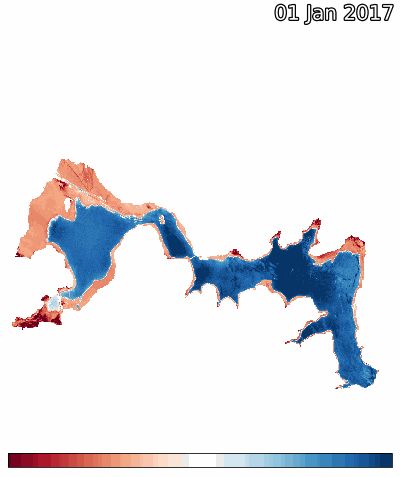

In [26]:
# Produce time series animation with a colour bar:
xr_animation(ds=ds_sen2,
             bands='NDWI', 
             output_path='animated_timeseries.gif',
             width_pixels=400,
             #show_text='NDWI',
             show_colorbar=True,
             
             #the red are the values < 0 (or the extent) and the blue = water
             imshow_kwargs={'cmap': 'RdBu'})#, 'vmin': 0.0, 'vmax': 0.5})

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

In [ ]:
# Animate datasets as a MP4 file
#xr_animation(ds_waterarea, 
             #bands='NDWI',
             #output_path='animated_timeseries.mp4')

### Quantify the difference 

> Here we create a dataframe with dates and coverage as a km^2 and percentage full and export a shapefile

In [27]:
#We could choose the WOfS as reference
nominal_2013 = gdf_clean['area'].sum()/100
print('Total surface area (given 2015 WOfS reference):', nominal_2013, 'km^2')

Total surface area (given 2015 WOfS reference): 72.0 km^2


> We choose to compare with the maximum result during the selected time period.

In [28]:
max_val = max(waterarea.values)
print('Total surface area (given max water observation 2017 - 2020):', round(max_val, 1), 'km^2')


Total surface area (given max water observation 2017 - 2020): 41.3 km^2


In [29]:
#create some columns with data

#percent full
percent_full = (waterarea.values/max_val) * 100

# change from max
change = waterarea.values - max_val

#change as a percent
Change_asPercent = (change/(max_val) * 100)

# Create and fill pandas dataframe 
dataset = pd.DataFrame({'Date': waterarea.time, 
                        'Water_area_km2': waterarea.values, 
                        'Percent_full [given max: 41.3]': percent_full,
                        'Change_area_km2': change,
                        'Change_asPercent': Change_asPercent})

In [30]:
#look
dataset.tail()

Date  Water_area_km2  Percent_full [given max: 41.3]  \
120 2020-05-30 08:49:51         32.7684                       79.368317   
121 2020-06-14 08:49:56         34.6750                       83.986291   
122 2020-06-19 08:49:52         34.6750                       83.986291   
123 2020-06-24 08:49:56         34.7982                       84.284694   
124 2020-07-19 08:49:51         37.8807                       91.750814   

     Change_area_km2  Change_asPercent  
120          -8.5181        -20.631683  
121          -6.6115        -16.013709  
122          -6.6115        -16.013709  
123          -6.4883        -15.715306  
124          -3.4058         -8.249186

In [31]:
# export as csv
dataset.to_csv(r'dataset.csv')#, index = False)

### Export a `.shp` file for a selected *time stamp* or *index*

In [32]:
#only select water
water = ds_waterarea.NDWI > 0.1

Thee_Extent = xr_vectorize(da=water[0].compute(),
                                     crs=ds_waterarea.crs,
                                     transform=ds_waterarea.geobox.transform,
                                     mask=water[0].values == 1,
                                       
                                       # append with the date of the index
                                     export_shp='Thee_Extent_%s.shp' % (ds_waterarea.time[0].dt.strftime('%Y-%m-%d-%H%M').data)
                                    )

Thee_Extent.head()

attribute                                           geometry
0        1.0  POLYGON ((328790.000 6237210.000, 328790.000 6...
1        1.0  POLYGON ((328830.000 6237200.000, 328830.000 6...
2        1.0  POLYGON ((328980.000 6237100.000, 328980.000 6...
3        1.0  POLYGON ((329000.000 6237090.000, 329000.000 6...
4        1.0  POLYGON ((329090.000 6237030.000, 329090.000 6...

In [33]:
Thee_Extent.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   attribute  47 non-null     float64 
 1   geometry   47 non-null     geometry
dtypes: float64(1), geometry(1)
memory usage: 880.0 bytes


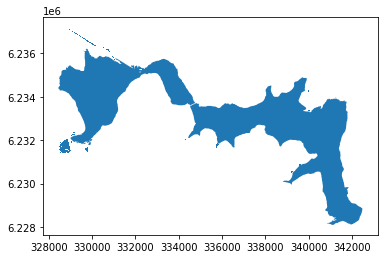

In [34]:
#check
Thee_Extent.plot()